# Loading the Census Income (KDD) Dataset
The `.names` file is a convention used by the UCI Machine Learning Repository to provide essential metadata about the datasets they host.

In [2]:
import time
from PIL import Image, ImageChops

# Importing necessary objects for data manipulation and analysis.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, make_scorer, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import TargetEncoder, LabelEncoder, StandardScaler
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline


In [3]:
# It's easier to extract useful infomration about column names and distinct values from the .names file then to write it out.
def parse_names():
    """
    Parses the .names file from the Census-Income (KDD) dataset to extract information about the variables.

    Returns:
        dict: A dictionary where each key is a variable name, and the value describes the variable as either 'continuous' or 'nominal'.
              For nominal variables, it includes the distinct values found in the dataset.
    """

    result = {}

    # The .names file doesn't follow a strict format.
    with open('../data/census/census-income.names', 'r') as file:
        text = file.read()

    # Just take lines that define attributes.
    etch = list(filter(lambda x: not (x.startswith('|') or x.startswith('-') or x.strip() == ''), text.splitlines()))
    for line in etch:
        key, value = map(lambda x: x.rstrip(".").strip(), line.split(':'))

        if value == "continuous":
            result[key] = {"type": "continuous"}
        else:
            values = list(map(lambda x: x.strip(), value.split(",")))

            # Try converting to an integer.
            try:
                values = list(map(int, values))
            except:
                pass
            result[key] = {"type": "nominal", "values": values}

    return result

In [4]:
# Invoke the built-in help system.
help(parse_names)

Help on function parse_names in module __main__:

parse_names()
    Parses the .names file from the Census-Income (KDD) dataset to extract information about the variables.
    
    Returns:
        dict: A dictionary where each key is a variable name, and the value describes the variable as either 'continuous' or 'nominal'.
              For nominal variables, it includes the distinct values found in the dataset.



In [5]:
# A 'codebook' is just something to help with understanding a dataset.
codebook = parse_names()

# The target is the last column in the dataset.
column_names = list(codebook.keys()) + ["income"]

In [6]:
train_df = pd.read_csv('../data/census/census-income.data', names=column_names, index_col=False)
train_df.shape

(199523, 42)

In [7]:
test_df = pd.read_csv('../data/census/census-income.test', names=column_names, index_col=False)
test_df.shape

(99762, 42)

# Exploring the Dataset

Pandas preserves spaces that are in the dataset, these spaces aren't important and can be removed while exploring.

Missing values show up in the dataset as '?'.

In [9]:
df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# You can check the column names, missing values, and data type.
df.replace('?', None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

In [10]:
# Find values that aren't listed in .names.
def display_unexpected_values(df, codebook):
    for key, value in codebook.items():
        if value["type"] == "continuous":
            continue

        expected_values = set(value["values"])
        actual_values = set(df[key].unique())
        unexpected_values = actual_values - expected_values

        if unexpected_values:
            print(f"{key}: {unexpected_values}")

# The .names file doens't talk about '?' as a posible value for the nominals which is why it's showing up.
display_unexpected_values(df, codebook)

state of previous residence: {'?'}
migration code-change in msa: {'?'}
migration code-change in reg: {'?'}
migration code-move within reg: {'?'}
migration prev res in sunbelt: {'?'}
country of birth father: {'?'}
country of birth mother: {'?'}
country of birth self: {'?'}


In [11]:
def calculate_missingness(df):
    for column in df.select_dtypes(include=['object']):
        missing_count = (df[column].str.strip() == "?").sum()
        total_count = len(df[column])
        missing_percentage = (missing_count / total_count) * 100
        if missing_count > 0:
            print(f"{column}: {missing_percentage:.2f}% missing")

# Computes the percentage of missing values represented by '?' for string columns in the dataset.
calculate_missingness(train_df)

state of previous residence: 0.35% missing
migration code-change in msa: 49.97% missing
migration code-change in reg: 49.97% missing
migration code-move within reg: 49.97% missing
migration prev res in sunbelt: 49.97% missing
country of birth father: 3.36% missing
country of birth mother: 3.07% missing
country of birth self: 1.70% missing


In [12]:
# Let's only look at columns that actually represent numeric data.
continuous = list(filter(lambda x: codebook[x]["type"] == "continuous" and x != "instance weight", codebook.keys()))

# Some of these values might be capped.
df[continuous].describe().T[["min", "max"]]

,min,max
age,0.0,90.0
wage per hour,0.0,9999.0
capital gains,0.0,99999.0
capital losses,0.0,4608.0
dividends from stocks,0.0,99999.0
num persons worked for employer,0.0,6.0
weeks worked in year,0.0,52.0


# Binary Classification Task

The **Census-Income (KDD)** dataset is derived from the **1994 and 1995 Current Population Surveys (CPS)** conducted by the U.S. Census Bureau.

It includes **199,523 training instances** and **99,762 test instances**.

The goal is to predict the income level based on the data provided in each row. Incomes have been binned at the $50K level to create a binary classification problem.

In [14]:
# List of categorical columns.
nominal = list(filter(lambda x: codebook[x]["type"] == "nominal", codebook.keys()))

# List of numerical columns.
continuous = list(filter(lambda x: codebook[x]["type"] == "continuous", codebook.keys()))

# Ignore 'instance weight'.
continuous.remove("instance weight")

# The 'instance weight' column happens to make the RandomForestClassifier more accurate.
# The dataset feels like a distribution problem to me instead of a prediction problem so I'd tend to use any columns that help with modeling the distribution.
# The .names file suggested to not use it... I don't even think there are real realtionships to learn in this data though.


## Encoding Categorical Features

The way features are encoded for this dataset doesn't seem to make much difference in the modeling.

Most columns do not have a natural ordering and should use One-Hot encoding for best performance!

The `OneHotEncoder` makes things substantially slower though, and I don't want to suffer through that.

In [16]:
def value_distribution(series):
    # Get value counts.
    value_counts = series.value_counts()
    
    # Calculate percentages.
    percentages = (value_counts / len(series)) * 100

    return pd.DataFrame({'count': value_counts, 'percentage': percentages})

# Values for each category column seem to have plenty of examples.
# for column in nominal:
#     display(value_distribution(df[column]))

### Encoding the Target
The traget can be encoded using the `LabelEncoder`.

In [18]:
label_encoder = LabelEncoder()

# Fit the encoder on training data.
label_encoder.fit(train_df["income"])

# Transform the training and test data.
y = label_encoder.transform(train_df["income"])
y_test = label_encoder.transform(test_df["income"])

# The unique values are sorted in lexicographical order.
label_encoder.classes_

array([' - 50000.', ' 50000+.'], dtype=object)

### Encoding the Features
The features can be encoded using `OrdinalEncoder` or `OneHotEncoder`.

But, the `OneHotEncoder` creates a bunch of additional columns and a `TargetEncoder` performs well enough.

In [20]:
# Encode categorical features.
encoder = TargetEncoder()

# Fit the encoder to the training data.
encoder.fit(train_df[nominal], y)

# Names for the encoded features.
feature_names = encoder.get_feature_names_out(nominal)

# Encode the training and test data.
X = pd.concat([pd.DataFrame(encoder.transform(train_df[nominal]), columns=feature_names), train_df[continuous]], axis=1)
X_test = pd.concat([pd.DataFrame(encoder.transform(test_df[nominal]), columns=feature_names), test_df[continuous]], axis=1)

## Scaling Features

You don't need to scale the categorical columns.

In [22]:
# Fit a standard scaler to training data.
scaler = StandardScaler()
scaler.fit(X[continuous])

# Transform the training data.
X[continuous] = scaler.transform(X[continuous])

# Transform the testing data.
X_test[continuous] = scaler.transform(X_test[continuous])

## Cross Validation

You could use cross validation to see how well the model performs for the given encodings.

In [24]:
model = RandomForestClassifier(random_state=42)
cross_val_score(model, X, y, cv=5)

array([0.95556948, 0.95554442, 0.95587019, 0.95434042, 0.95551824])

## Dealing With Class Imbalance

Resampling teaches the model to guess the minority class more frequently with worse precision.

In [26]:
def display_class_imbalance(target):
    class_0_count = np.count_nonzero(target == 0)
    class_1_count = np.count_nonzero(target == 1)
    total_count = len(target)

    # Calculate the percentages.
    class_0_percentage = (class_0_count / total_count) * 100
    class_1_percentage = (class_1_count / total_count) * 100

    print(f"Class 0: {class_0_count} instances, {class_0_percentage}% of the total")
    print(f"Class 1: {class_1_count} instances, {class_1_percentage}% of the total")

In [27]:
display_class_imbalance(y_test)

Class 0: 93576 instances, 93.7992421964275% of the total
Class 1: 6186 instances, 6.200757803572503% of the total


In [28]:
def balanced_accuracy_with_report(y_true, y_predication):
    print("\nClassification Report:\n", classification_report(y_true, y_predication))
    return balanced_accuracy_score(y_true, y_predication)

scorer = make_scorer(balanced_accuracy_with_report)

In [29]:
def time_cross_val_score(X, y, model, sampler, cv=5, scoring='balanced_accuracy'):
    # Create a pipeline with the provided sampler and model instances.
    pipeline = ImbPipeline(steps=[('resample', sampler), ('model', model)])

    # Time the cross-validation process.
    start_time = time.time()
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer)
    end_time = time.time()

    # Calculate the elapsed time.
    elapsed_time = end_time - start_time
    print(f"Cross-validation with {model.__class__.__name__} and {sampler.__class__.__name__}: {elapsed_time:.2f} seconds")

    # Return the cross-validation scores.
    return cv_scores

In [30]:
# Random Oversampling 😂
# ❌ 💥🤯🔥💣 😈 😈 😈 🐖 🐖 🐖
time_cross_val_score(X, y, RandomForestClassifier(random_state=42), RandomOverSampler(random_state=42))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37429
           1       0.63      0.51      0.56      2476

    accuracy                           0.95     39905
   macro avg       0.80      0.75      0.77     39905
weighted avg       0.95      0.95      0.95     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37428
           1       0.63      0.51      0.56      2477

    accuracy                           0.95     39905
   macro avg       0.80      0.74      0.77     39905
weighted avg       0.95      0.95      0.95     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37428
           1       0.64      0.51      0.57      2477

    accuracy                           0.95     39905
   macro avg       0.80      0.75      0.77     39905

array([0.74540666, 0.74344499, 0.74582426, 0.74290452, 0.7362508 ])

In [31]:
# Random Undersampling
time_cross_val_score(X, y, RandomForestClassifier(random_state=42), RandomUnderSampler(random_state=42))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     37429
           1       0.29      0.90      0.43      2476

    accuracy                           0.85     39905
   macro avg       0.64      0.88      0.68     39905
weighted avg       0.95      0.85      0.89     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     37428
           1       0.29      0.89      0.43      2477

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     37428
           1       0.29      0.90      0.44      2477

    accuracy                           0.85     39905
   macro avg       0.64      0.88      0.68     39905

array([0.87651981, 0.87133551, 0.87725017, 0.86843936, 0.86748714])

In [32]:
# Cluster Centroids
time_cross_val_score(X, y, RandomForestClassifier(random_state=42), ClusterCentroids(random_state=42))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.47      0.63     37429
           1       0.11      0.96      0.19      2476

    accuracy                           0.50     39905
   macro avg       0.55      0.71      0.41     39905
weighted avg       0.94      0.50      0.61     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.47      0.64     37428
           1       0.11      0.96      0.19      2477

    accuracy                           0.50     39905
   macro avg       0.55      0.71      0.41     39905
weighted avg       0.94      0.50      0.61     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.46      0.63     37428
           1       0.11      0.96      0.19      2477

    accuracy                           0.50     39905
   macro avg       0.55      0.71      0.41     39905

array([0.71224467, 0.71325221, 0.71456264, 0.71299588, 0.71304247])

In [33]:
# Synthetic Minority Oversampling Technique (SMOTE)
time_cross_val_score(X, y, RandomForestClassifier(random_state=42), SMOTE(random_state=42))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37429
           1       0.64      0.49      0.56      2476

    accuracy                           0.95     39905
   macro avg       0.80      0.74      0.76     39905
weighted avg       0.95      0.95      0.95     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37428
           1       0.63      0.49      0.55      2477

    accuracy                           0.95     39905
   macro avg       0.80      0.73      0.76     39905
weighted avg       0.95      0.95      0.95     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     37428
           1       0.64      0.49      0.55      2477

    accuracy                           0.95     39905
   macro avg       0.80      0.74      0.76     39905

array([0.73689228, 0.73344271, 0.73508281, 0.72737731, 0.72715579])

In [34]:
# SMOTE and Edited Nearest Neighbors (SMOTEENN)
time_cross_val_score(X, y, RandomForestClassifier(random_state=42), SMOTEENN(random_state=42))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     37429
           1       0.47      0.71      0.57      2476

    accuracy                           0.93     39905
   macro avg       0.72      0.83      0.76     39905
weighted avg       0.95      0.93      0.94     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     37428
           1       0.47      0.70      0.56      2477

    accuracy                           0.93     39905
   macro avg       0.72      0.83      0.76     39905
weighted avg       0.95      0.93      0.94     39905


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     37428
           1       0.47      0.69      0.56      2477

    accuracy                           0.93     39905
   macro avg       0.73      0.82      0.76     39905

array([0.82919209, 0.82555978, 0.82136833, 0.81581869, 0.82323388])

## Evaluating a Model

The RandomForestClassifier is relatively robust, as it isn't significantly affected by how features are encoded or scaled, and it shows some resistance to irrelevant columns as well.

In [36]:
# Fit with training data.
model = RandomForestClassifier(random_state=42)
model.fit(X, y);

In [37]:
# Predict with testing data.
predictions = model.predict(X_test)

In [38]:
# The correct labels should come first. I had flipped these before giving me bad looking results.
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.74      0.45      0.56      6186

    accuracy                           0.96     99762
   macro avg       0.85      0.72      0.77     99762
weighted avg       0.95      0.96      0.95     99762



In [39]:
# Reversed these by mistake.
print(balanced_accuracy_score(y_test, predictions))

0.7191846664240384


In [40]:
# Measures the model's ability to distinguish between classes.
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9394319529856986

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

# Measures the model's ability to balance precision and recall across different thresholds.
auc(recall, precision)

0.650550455095561

In [42]:
predict_probabilities = model.predict_proba(X_test)[:, 1]

for threshold in np.arange(0.1, 1.0, 0.1):
    threshold_predictions = (predict_probabilities >= threshold).astype(int)

    # Calculate precision and recall.
    precision = precision_score(y_test, threshold_predictions)
    recall = recall_score(y_test, threshold_predictions)

    print(f'Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f}')

Threshold: 0.10 | Precision: 0.3255 | Recall: 0.8603
Threshold: 0.20 | Precision: 0.4539 | Recall: 0.7544
Threshold: 0.30 | Precision: 0.5681 | Recall: 0.6387
Threshold: 0.40 | Precision: 0.6547 | Recall: 0.5521
Threshold: 0.50 | Precision: 0.7286 | Recall: 0.4562
Threshold: 0.60 | Precision: 0.8001 | Recall: 0.3526
Threshold: 0.70 | Precision: 0.8652 | Recall: 0.2593
Threshold: 0.80 | Precision: 0.9257 | Recall: 0.1693
Threshold: 0.90 | Precision: 0.9566 | Recall: 0.0784


### Figures

Does this section serve a purpose? I'm not sure, but if I make it available to myself I may find a purpose for it later.


In [44]:
cm = confusion_matrix(y_test, predictions)
cm

array([[92589,   987],
       [ 3409,  2777]])

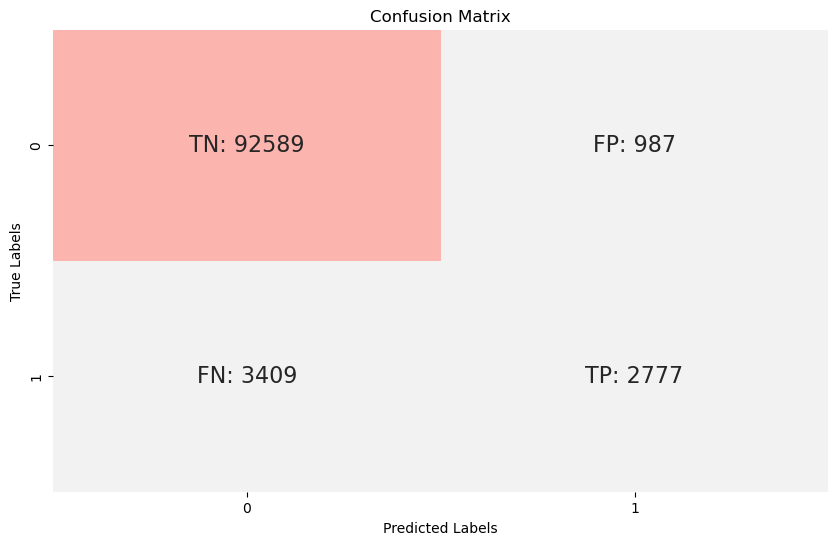

In [45]:
labels = np.array([
    [f"TN: {cm[0, 0]}", f"FP: {cm[0, 1]}"],
    [f"FN: {cm[1, 0]}", f"TP: {cm[1, 1]}"]
])

plt.figure(figsize=(10, 6))

sns.heatmap(cm, cmap=colormaps['Pastel1_r'], cbar=False, annot=labels, fmt='', annot_kws={"size": 16})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('../results/cm.png', bbox_inches='tight')

plt.show()


In [46]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

top_10 = importance_df.sort_values(by='Importance', ascending=False).head(10)


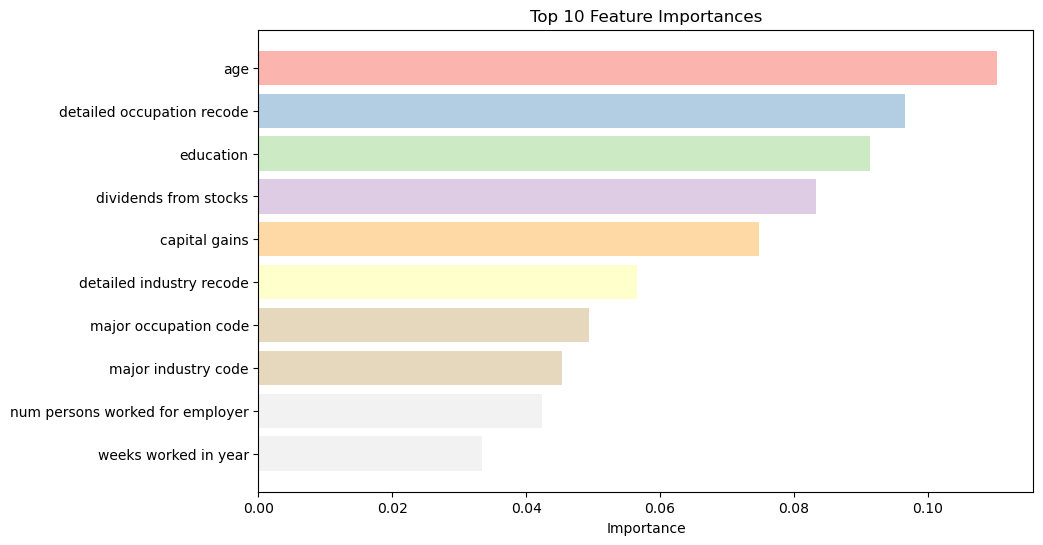

In [47]:
plt.figure(figsize=(10, 6))

plt.barh(top_10['Feature'], top_10['Importance'], color=colormaps['Pastel1'](np.linspace(0, 1, len(top_10))))

plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')

plt.gca().invert_yaxis()

plt.savefig('../results/top_10_feature_importances.png', bbox_inches='tight')

plt.show()


In [48]:
def crop(path):
    img = Image.open(path)
    
    gray_img = img.convert("L")
    inverted_img = ImageChops.invert(gray_img)
    bbox = inverted_img.getbbox()

    padding = 10
    bbox = (bbox[0] - padding, bbox[1] - padding, bbox[2] + padding, bbox[3] + padding)
    cropped_img = img.crop(bbox)

    cropped_img.save(path)

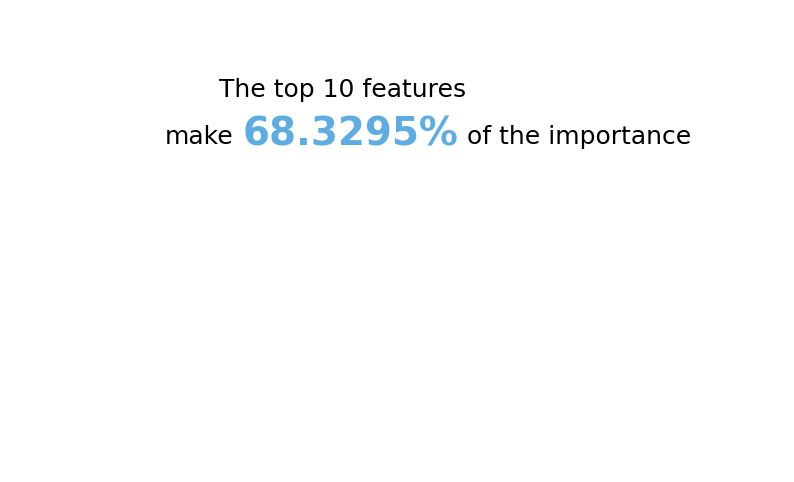

In [49]:
plt.figure(figsize=(10, 6))

# Top text
plt.text(0.27, 0.8, 'The top 10 features', fontsize=18, ha='left', va="bottom", color='black')

# Left text
plt.text(0.2, 0.7, 'make', fontsize=18, ha='left', va="bottom", color='black')

# Middle text
plt.text(0.3, 0.69, format(top_10["Importance"].sum(), ".4%"), fontsize=28, ha='left', va="bottom", color='#5DADE2', fontweight='bold')

# Right text
plt.text(0.59, 0.7, 'of the importance', fontsize=18, ha='left', va="bottom", color='black')

plt.gca().axis('off')

plt.savefig('../results/top_10_feature_importances_percentage.png')
crop('../results/top_10_feature_importances_percentage.png')

plt.show()


In [50]:
# Probabilities for ROC and AUC
predicted_proba_class_1 = model.predict_proba(X_test)[:, 1]

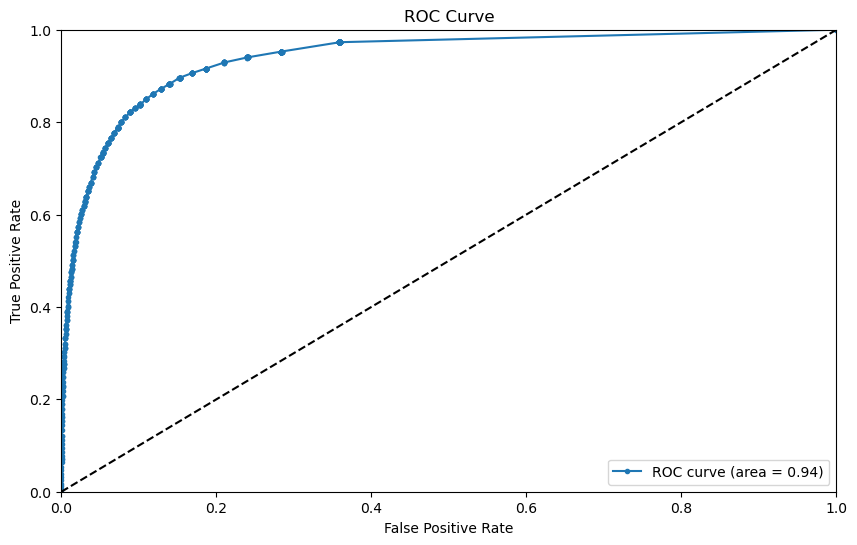

In [51]:
fpr, tpr, _ = roc_curve(y_test, predicted_proba_class_1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', marker=".")
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.savefig('../results/roc_curve.png', bbox_inches='tight')

plt.show()


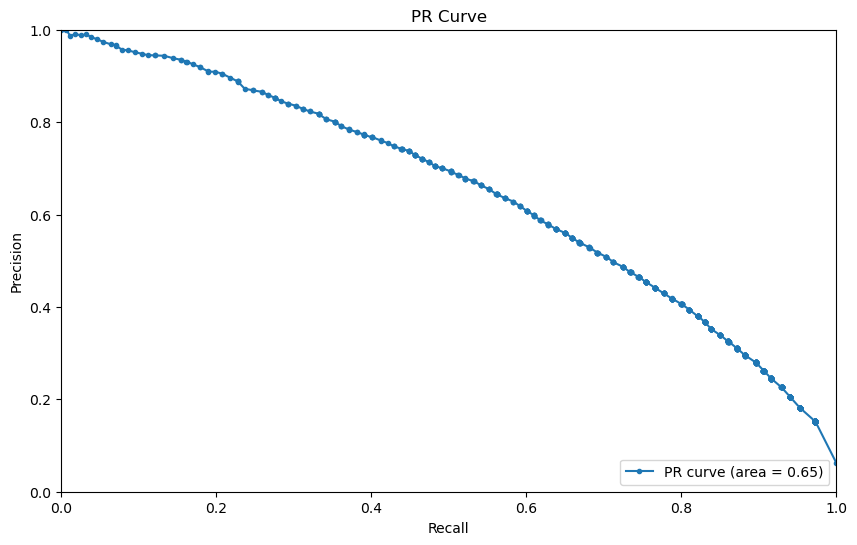

In [52]:
precision, recall, _ = precision_recall_curve(y_test, predicted_proba_class_1)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))

plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})', marker='.')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.savefig('../results/pr_curve.png', bbox_inches='tight')

plt.show()
